<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Deploy a model in the cloud - P8</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Notebook - Proof of Concept |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries & static variables</h2>
</div>

In [1]:
## General
import numpy as np
from io import BytesIO
from PIL import Image

## Spark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import (input_file_name, col, split,
                                   pandas_udf, PandasUDFType)
import sagemaker_pyspark

## To use S3 files
import botocore.session
import boto3

In [2]:
BUCKET = "oc-p8-bucket"
SUBFOLDER = "test/images/"
DUMMY_FILE = "SampleCSVFile_556kb.csv"

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1 loading the sagemaker jars </h3>
</div>

In [3]:
conf = (SparkConf()
        .set("spark.driver.extraClassPath", ":".join(sagemaker_pyspark.classpath_jars())))
SparkContext(conf=conf)

<SparkContext master=local[*] appName=pyspark-shell>

<div class="alert alert-block alert-info">
    <p>Here, we can notice which is the Spark's version (2.4 LTS).<br>
        It is not the latest version but, as of today (2022/03), it is still a tested version with support.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Testing connection to S3</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to print the name of the first 5 elements in the S3.</p>
</div>

In [4]:
conn = boto3.client("s3")

In [5]:
contents = conn.list_objects(Bucket=BUCKET)["Contents"]
for k in list(contents)[:5]:
    print(k["Key"])

SampleCSVFile_556kb.csv
test/
test/images/
test/images/Apricot/0_100.jpg
test/images/Apricot/123_100.jpg


<div class="alert alert-block alert-info">
    <p>Now, we are going to test whether we can read an image from S3.</p>
</div>

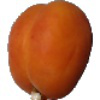

In [6]:
test_img = Image.open(
            BytesIO(
                conn.get_object(
                    Bucket=BUCKET, 
                    Key=list(contents)[5]["Key"])["Body"].read()
            )
        )

test_img

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Spark session</h2>
</div>

In [7]:
session = botocore.session.get_session()
credentials = session.get_credentials()

In [8]:
spark = (
    SparkSession
    .builder
    .appName("P8-FRUITS")
    .config(conf=conf)
    .config("fs.s3a.access.key", credentials.access_key)
    .config("fs.s3a.secret.key", credentials.secret_key)
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
    .config("spark.jars.packages", "databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11")
    .getOrCreate()
)

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1 Testing connection to S3 with Spark</h3>
</div>

In [9]:
data_location = "s3a://{}/{}".format(BUCKET, DUMMY_FILE)

In [10]:
df_dummy = spark.read.csv(data_location, header="True", inferSchema=True)
df_dummy = df_dummy.drop("1")

In [11]:
df_dummy.limit(5).toPandas()

,"Eldon Base for stackable storage shelf, platinum",Muhammed MacIntyre,3,-213.25,38.94,35,Nunavut,Storage & Organization,0.8
0,"""1.7 Cubic Foot Compact """"Cube"""" Office Refrig...",Barry French,293,457.81,208.16,68.02,Nunavut,Appliances,0.58
1,"Cardinal Slant-D� Ring Binder, Heavy Gauge Vinyl",Barry French,293,46.71,8.69,2.99,Nunavut,Binders and Binder Accessories,0.39
2,R380,Clay Rozendal,483,1198.97,195.99,3.99,Nunavut,Telephones and Communication,0.58
3,Holmes HEPA Air Purifier,Carlos Soltero,515,30.94,21.78,5.94,Nunavut,Appliances,0.5
4,G.E. Longer-Life Indoor Recessed Floodlight Bulbs,Carlos Soltero,515,4.43,6.64,4.95,Nunavut,Office Furnishings,0.37


In [12]:
df_dummy.printSchema()

root
 |-- Eldon Base for stackable storage shelf, platinum: string (nullable = true)
 |-- Muhammed MacIntyre: string (nullable = true)
 |-- 3: string (nullable = true)
 |-- -213.25: string (nullable = true)
 |-- 38.94: string (nullable = true)
 |-- 35: string (nullable = true)
 |-- Nunavut: string (nullable = true)
 |-- Storage & Organization: string (nullable = true)
 |-- 0.8: string (nullable = true)



<div class="alert alert-block alert-success">
    <p>Great!, we can access to S3 from ours Notebook through Spark / Pyspark</p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2 Testing reading and image from S3 through Spark</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, let's try to read an image from the bucket</p>
</div>

In [13]:
image = spark.read.format("image").load("s3a://{}/{}".format(BUCKET, list(contents)[5]["Key"]))

In [14]:
image.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [15]:
image.show()

+--------------------+
|               image|
+--------------------+
|[s3a://oc-p8-buck...|
+--------------------+



In [16]:
img = image.first()

In [17]:
img = np.array(img.asDict()["image"]["data"]).reshape(100, 100, 3)[:, :, ::-1]

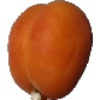

In [18]:
Image.fromarray(img, "RGB")

<div class="alert alert-block alert-success">
    <p>So far, We have access to an image. Let's go to read all images in the bucket.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Reading images with Spark</h2>
</div>

<div class="alert alert-block alert-info">
    <p>To read the images, we will restrict the format only to *.jpg. In addition, we will read all subdirectories in the main directory.</p>
</div>

In [19]:
df_images = spark.read.format("image")\
      .option("pathGlobFilter", "*.jpg")\
      .option("recursiveFileLookup", "true")\
      .load("s3a://{}/{}/*".format(BUCKET, SUBFOLDER))

In [20]:
df_images.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [21]:
df_images.show(5)

+--------------------+
|               image|
+--------------------+
|[s3a://oc-p8-buck...|
|[s3a://oc-p8-buck...|
|[s3a://oc-p8-buck...|
|[s3a://oc-p8-buck...|
|[s3a://oc-p8-buck...|
+--------------------+
only showing top 5 rows



<div class="alert alert-block alert-info">
    <p>Let's get the path and the category of the each image.</p>
</div>

In [22]:
df_images = df_images.withColumn("path", input_file_name())
df_images = df_images.withColumn("category", split(col("path"), "/").getItem(5))
df_images.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- path: string (nullable = false)
 |-- category: string (nullable = true)



In [23]:
df_images.select("image", "image.width", "image.height", "path", "category", "image.data").show(5, truncate=True)

+--------------------+-----+------+--------------------+----------+--------------------+
|               image|width|height|                path|  category|                data|
+--------------------+-----+------+--------------------+----------+--------------------+
|[s3a://oc-p8-buck...|  100|   100|s3a://oc-p8-bucke...| Raspberry|[FF FF FB FF FF F...|
|[s3a://oc-p8-buck...|  100|   100|s3a://oc-p8-bucke...| Raspberry|[FF FF FF FF FE F...|
|[s3a://oc-p8-buck...|  100|   100|s3a://oc-p8-bucke...| Raspberry|[FD FF FF FF FF F...|
|[s3a://oc-p8-buck...|  100|   100|s3a://oc-p8-bucke...| Raspberry|[FA FF F9 FB FF F...|
|[s3a://oc-p8-buck...|  100|   100|s3a://oc-p8-bucke...|Watermelon|[FF FF FF FF FF F...|
+--------------------+-----+------+--------------------+----------+--------------------+
only showing top 5 rows



<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Featurization for transfer learning</h2>
</div>

In [1]:
import sparkdl

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorframes'

In [ ]:
## TensorFlow
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

import pandas as pd
import io

In [ ]:
model = ResNet50(include_top=False)

In [58]:
bc_model_weights = spark.sparkContext.broadcast(model.get_weights())

In [59]:
def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights=None, include_top=False) 
    model.set_weights(bc_model_weights.value)
    return model

In [136]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
#     img = Image.open(io.BytesIO(content)).resize([224, 224])
#     img = Image.frombytes("RGB", (224, 224), content)
    img = np.array(content.asDict()["image"]["data"]).reshape(100, 100, 3)[:, :, ::-1]
    img = Image.fromarray(img, "RGB")
    arr = img_to_array(img)
    return preprocess_input(arr) 

In [137]:
def featurize_series(model, content_series):
    
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
#     input = np.stack(content_series.map(preprocess)) 

    input = np.stack(preprocess(content_series))
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [138]:
def feature_extraction(x):
    
    path = x.path
    category = x.category
    
    content_series = x
    
    model = model_fn()
    feature = featurize_series(model, content_series)

    return (path, category, feature)

In [144]:
def test(x):
    
    model = model_fn()

    
    path = x.path
    category = x.category
    print("1")

    
    
    

    return (path, category, "flag")

In [145]:
rdd_images = df_images.rdd.map(lambda x: test(x))

In [146]:
rdd_images.collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 37.0 failed 1 times, most recent failure: Lost task 0.0 in stage 37.0 (TID 77, localhost, executor driver): java.net.SocketException: Connection reset
	at java.net.SocketInputStream.read(SocketInputStream.java:210)
	at java.net.SocketInputStream.read(SocketInputStream.java:141)
	at java.io.BufferedInputStream.fill(BufferedInputStream.java:246)
	at java.io.BufferedInputStream.read(BufferedInputStream.java:265)
	at java.io.DataInputStream.readInt(DataInputStream.java:387)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:578)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:945)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor69.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.net.SocketException: Connection reset
	at java.net.SocketInputStream.read(SocketInputStream.java:210)
	at java.net.SocketInputStream.read(SocketInputStream.java:141)
	at java.io.BufferedInputStream.fill(BufferedInputStream.java:246)
	at java.io.BufferedInputStream.read(BufferedInputStream.java:265)
	at java.io.DataInputStream.readInt(DataInputStream.java:387)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:578)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:945)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
df_features = spark.createDataFrame(data=rdd_images, schema=["path", "category", "feature"])

In [42]:
df_features.show(5)

+--------------------+----------+--------------------+
|                path|  category|             feature|
+--------------------+----------+--------------------+
|s3a://oc-p8-bucke...| Raspberry|[FF FF FB FF FF F...|
|s3a://oc-p8-bucke...| Raspberry|[FF FF FF FF FE F...|
|s3a://oc-p8-bucke...| Raspberry|[FD FF FF FF FF F...|
|s3a://oc-p8-bucke...| Raspberry|[FA FF F9 FB FF F...|
|s3a://oc-p8-bucke...|Watermelon|[FF FF FF FF FF F...|
+--------------------+----------+--------------------+
only showing top 5 rows



In [44]:
df_features.printSchema()

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- feature: binary (nullable = true)



In [245]:
# example A
def getNumber():
    for r in range(1,10):
        return r

In [247]:
a = getNumber()

In [248]:
a

1

In [249]:
# example B
def getNumber():
    for r in range(1,10):
        yield r

In [250]:
a = getNumber()

In [252]:
type(a)

generator

<div style="background-color: red;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">&gt;&gt;&gt; FLAG &lt;&lt;&lt;</h1>
</div>

In [213]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from pyspark.sql.functions import col, pandas_udf, PandasUDFType

In [214]:
model = ResNet50(include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [217]:
bc_model_weights = spark.sparkContext.broadcast(model.get_weights())

def model_fn():
  """
  Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
  """
  model = ResNet50(weights=None, include_top=False)
  model.set_weights(bc_model_weights.value)
  return model

In [218]:
def preprocess(content):
  """
  Preprocesses raw image bytes for prediction.
  """
  img = Image.open(io.BytesIO(content)).resize([224, 224])
  arr = img_to_array(img)
  return preprocess_input(arr)

def featurize_series(model, content_series):
  """
  Featurize a pd.Series of raw images using the input model.
  :return: a pd.Series of image features
  """
  input = np.stack(content_series.map(preprocess))
  preds = model.predict(input)
  # For some layers, output features will be multi-dimensional tensors.
  # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
  output = [p.flatten() for p in preds]
  return pd.Series(output)

In [254]:
@pandas_udf('array<float>', PandasUDFType.SCALAR)
def featurize_udf(content_series_iter):
  '''
  This method is a Scalar Iterator pandas UDF wrapping our featurization function.
  The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
  :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
  '''
  # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
  # for multiple data batches.  This amortizes the overhead of loading big models.
  model = model_fn()
  for content_series in content_series_iter:
    yield featurize_series(model, content_series)

In [255]:
features_df = df_images.select(col("path"), col("category"), featurize_udf("image.data").alias("features"))

In [256]:
features_df.printSchema()

root
 |-- path: string (nullable = false)
 |-- category: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [257]:
features_df.show(2)

Py4JJavaError: An error occurred while calling o2278.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 89.0 failed 1 times, most recent failure: Lost task 0.0 in stage 89.0 (TID 93, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 283, in dump_stream
    for series in iterator:
  File "<string>", line 1, in <lambda>
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 96, in <lambda>
    return lambda *a: (verify_result_length(*a), arrow_return_type)
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 90, in verify_result_length
    "Pandas.Series, but is {}".format(type(result)))
TypeError: Return type of the user-defined function should be Pandas.Series, but is <class 'generator'>

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:98)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:96)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:89)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3384)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3365)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3364)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2545)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2759)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:255)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:292)
	at sun.reflect.GeneratedMethodAccessor84.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 283, in dump_stream
    for series in iterator:
  File "<string>", line 1, in <lambda>
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 96, in <lambda>
    return lambda *a: (verify_result_length(*a), arrow_return_type)
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 90, in verify_result_length
    "Pandas.Series, but is {}".format(type(result)))
TypeError: Return type of the user-defined function should be Pandas.Series, but is <class 'generator'>

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:98)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:96)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:89)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


<div style="background-color: red;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">&gt;&gt;&gt; FLAG &lt;&lt;&lt;</h1>
</div>

In [269]:
## TensorFlow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [270]:
model = VGG16(weights="imagenet", include_top=False)

In [284]:
def feature_extraction(x):
    
    path = x.path
    category = x.category
#     image = x.image.data
    
#     image = np.expand_dims(image, axis=0)
#     image = preprocess_input(image)
        
#     # Getting the descriptors based on the model predict
#     vgg16_feature = model.predict(image, use_multiprocessing=True)
#     vgg16_feature = np.array(vgg16_feature)
#     feature = vgg16_feature.flatten()
    
        
    return (path, category)

In [285]:
rdd_images = df_images.rdd.map(lambda x: feature_extraction(x))

In [286]:
df_images.show(2)

+--------------------+--------------------+---------+
|               image|                path| category|
+--------------------+--------------------+---------+
|[s3a://oc-p8-buck...|s3a://oc-p8-bucke...|Raspberry|
|[s3a://oc-p8-buck...|s3a://oc-p8-bucke...|Raspberry|
+--------------------+--------------------+---------+
only showing top 2 rows



In [287]:
rdd_images.collect()

[('s3a://oc-p8-bucket/test/images/Raspberry/272_100.jpg', 'Raspberry'),
 ('s3a://oc-p8-bucket/test/images/Raspberry/24_100.jpg', 'Raspberry'),
 ('s3a://oc-p8-bucket/test/images/Raspberry/9_100.jpg', 'Raspberry'),
 ('s3a://oc-p8-bucket/test/images/Raspberry/119_100.jpg', 'Raspberry'),
 ('s3a://oc-p8-bucket/test/images/Watermelon/145_100.jpg', 'Watermelon'),
 ('s3a://oc-p8-bucket/test/images/Watermelon/210_100.jpg', 'Watermelon'),
 ('s3a://oc-p8-bucket/test/images/Watermelon/r_27_100.jpg', 'Watermelon'),
 ('s3a://oc-p8-bucket/test/images/Watermelon/298_100.jpg', 'Watermelon'),
 ('s3a://oc-p8-bucket/test/images/Watermelon/r_255_100.jpg', 'Watermelon'),
 ('s3a://oc-p8-bucket/test/images/Watermelon/r_123_100.jpg', 'Watermelon'),
 ('s3a://oc-p8-bucket/test/images/Watermelon/r_195_100.jpg', 'Watermelon'),
 ('s3a://oc-p8-bucket/test/images/Watermelon/r_225_100.jpg', 'Watermelon'),
 ('s3a://oc-p8-bucket/test/images/Watermelon/r_153_100.jpg', 'Watermelon'),
 ('s3a://oc-p8-bucket/test/images/Wate

In [290]:
df_features = spark.createDataFrame(data=rdd_images)

In [291]:
df_features.show(5)

+--------------------+----------+
|                  _1|        _2|
+--------------------+----------+
|s3a://oc-p8-bucke...| Raspberry|
|s3a://oc-p8-bucke...| Raspberry|
|s3a://oc-p8-bucke...| Raspberry|
|s3a://oc-p8-bucke...| Raspberry|
|s3a://oc-p8-bucke...|Watermelon|
+--------------------+----------+
only showing top 5 rows



In [203]:
value = df_images.select("image.data").take(1)

<div style="background-color: red;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">&gt;&gt;&gt; FLAG &lt;&lt;&lt;</h1>
</div>

<div style="background-color: black;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">&gt;&gt;&gt; FLAG &lt;&lt;&lt;</h1>
</div>

In [185]:
## TensorFlow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [197]:
model = VGG16(weights="imagenet", include_top=False)

In [ ]:
features_df = df_images.select(col("path"), col("category"), feature_extraction("image.data").alias("features"))

<div style="background-color: black;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">&gt;&gt;&gt; FLAG &lt;&lt;&lt;</h1>
</div>

In [126]:
features_df = df_images.select(col("path"), col("category"), feature_extraction(col("image.data"), df_images.count()).alias("features")).take(df_images.count())
#features_df.show(2)

96
Column<b'image.data[10][0]'>


In [42]:
data = [('James','Smith','M',30),('Anna','Rose','F',41),
  ('Robert','Williams','M',62), 
]
columns = ["firstname","lastname","gender","salary"]
df = spark.createDataFrame(data=data, schema=columns)
df.show()

+---------+--------+------+------+
|firstname|lastname|gender|salary|
+---------+--------+------+------+
|    James|   Smith|     M|    30|
|     Anna|    Rose|     F|    41|
|   Robert|Williams|     M|    62|
+---------+--------+------+------+



In [51]:
# By Calling function
def func1(x):
    firstName=x.firstname
    lastName=x.lastname
    name=firstName+","+lastName
    gender=x.gender.lower()
    salary=x.salary*2
    return (name, salary)

rdd2 = df.rdd.map(lambda x: func1(x))

In [47]:
type(rdd2)

pyspark.rdd.PipelinedRDD

In [52]:
rdd2.collect()

[('James,Smith', 60), ('Anna,Rose', 82), ('Robert,Williams', 124)]

In [55]:
otro = spark.createDataFrame(data=rdd2, schema=["name", "salary"])
otro.show()

+---------------+------+
|           name|salary|
+---------------+------+
|    James,Smith|    60|
|      Anna,Rose|    82|
|Robert,Williams|   124|
+---------------+------+



In [42]:

# importing necessary libraries
from pyspark.sql import SparkSession
  
# function to create new SparkSession
def create_session():
  spk = SparkSession.builder \
      .appName("Corona_cases_statewise.com") \
      .getOrCreate()
  return spk
  
# function to create RDD
def create_RDD(sc,data):
  df = sc.parallelize(data)
  return df
  
# function to convert RDD to dataframe
def RDD_to_df(df,schema):
    
  # converting RDD to dataframe using toDF()
  # in which we are passing schema of df
  df = df.toDF(schema)
  return df


In [45]:
  
if __name__ == "__main__":
      
  input_data = [("Uttar Pradesh",122000,89600,12238),
          ("Maharashtra",454000,380000,67985),
          ("Tamil Nadu",115000,102000,13933),
          ("Karnataka",147000,111000,15306),
          ("Kerala",153000,124000,5259)]
  
  # calling function to create SparkSession
  spark = create_session()
  
  # creating spark context object
  sc = spark.sparkContext
  
  # calling function to create RDD
  rd_df = create_RDD(sc, input_data)
  
  schema_lst = ["State","Cases","Recovered","Deaths"]
  
  # calling function to covert RDD to dataframe
  converted_df = RDD_to_df(rd_df, schema_lst)
    
  # visualizing the schema and dataframe
  converted_df.printSchema()
  converted_df.show()

root
 |-- State: string (nullable = true)
 |-- Cases: long (nullable = true)
 |-- Recovered: long (nullable = true)
 |-- Deaths: long (nullable = true)

+-------------+------+---------+------+
|        State| Cases|Recovered|Deaths|
+-------------+------+---------+------+
|Uttar Pradesh|122000|    89600| 12238|
|  Maharashtra|454000|   380000| 67985|
|   Tamil Nadu|115000|   102000| 13933|
|    Karnataka|147000|   111000| 15306|
|       Kerala|153000|   124000|  5259|
+-------------+------+---------+------+



In [2]:
from sparkdl import DeepImageFeaturizer

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorframes'

In [115]:
type(df_tem[0][0])

bytearray

In [127]:
featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features", modelName="InceptionV3")

NameError: name 'DeepImageFeaturizer' is not defined

In [34]:
df_images.select("image", "image.width", "image.height", "path", "category", "image.data").show(5, truncate=True)

+--------------------+-----+------+--------------------+----------+--------------------+
|               image|width|height|                path|  category|                data|
+--------------------+-----+------+--------------------+----------+--------------------+
|[s3a://oc-p8-buck...|  100|   100|s3a://oc-p8-bucke...| Raspberry|[FF FF FB FF FF F...|
|[s3a://oc-p8-buck...|  100|   100|s3a://oc-p8-bucke...| Raspberry|[FF FF FF FF FE F...|
|[s3a://oc-p8-buck...|  100|   100|s3a://oc-p8-bucke...| Raspberry|[FD FF FF FF FF F...|
|[s3a://oc-p8-buck...|  100|   100|s3a://oc-p8-bucke...| Raspberry|[FA FF F9 FB FF F...|
|[s3a://oc-p8-buck...|  100|   100|s3a://oc-p8-bucke...|Watermelon|[FF FF FF FF FF F...|
+--------------------+-----+------+--------------------+----------+--------------------+
only showing top 5 rows



In [41]:
df_tem = df_images.select("*")

In [43]:
rdd = df_tem.rdd.map(lambda loop: (
    loop["image"], loop["path"]
))

In [44]:
rdd

PythonRDD[48] at RDD at PythonRDD.scala:53

In [45]:
df2 = rdd.toDF(["image","path"])

In [46]:
df2.show(6)

+--------------------+--------------------+
|               image|                path|
+--------------------+--------------------+
|[s3a://oc-p8-buck...|s3a://oc-p8-bucke...|
|[s3a://oc-p8-buck...|s3a://oc-p8-bucke...|
|[s3a://oc-p8-buck...|s3a://oc-p8-bucke...|
|[s3a://oc-p8-buck...|s3a://oc-p8-bucke...|
|[s3a://oc-p8-buck...|s3a://oc-p8-bucke...|
|[s3a://oc-p8-buck...|s3a://oc-p8-bucke...|
+--------------------+--------------------+
only showing top 6 rows



In [ ]:
#df_images = df_images.withColumn("category", split(col("path"), "/").getItem(5))

In [47]:
rows_looped = df_images.select("image.data").collect()

In [49]:

i i
for row in rows_looped:
    print(row[0])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [51]:

 
def create_df(spark, data, schema):
    df1 = spark.createDataFrame(data, schema)
    return df1

input_data = [(1, "Shivansh", "Data Scientist", 2000000, "Noida"),
                  (2, "Rishabh", "Software Developer", 1500000, "Banglore"),
                  (3, "Swati", "Data Analyst", 1000000, "Hyderabad"),
                  (4, "Amar", "Data Analyst", 950000, "Noida"),
                  (5, "Arpit", "Android Developer", 1600000, "Pune"),
                  (6, "Ranjeet", "Python Developer", 1800000, "Gurugram"),
                  (7, "Priyanka", "Full Stack Developer", 2200000, "Banglore")]
 
schema = ["Id", "Name", "Job Profile", "Salary", "City"]

# calling function to create dataframe
df = create_df(spark, input_data, schema)

# getting each row of dataframe containing
# only selected columns Selected columns are
# 'Name' and 'Salary' getting the list of rows
# with selected column data using collect()
rows_looped = df.select("Name", "Salary").collect()

# printing the data of each row
for rows in rows_looped:

    # here index 0 and 1 refers to the data
    # of 'Name' column and 'Salary' column
    print(rows[0], rows[1])

Shivansh 2000000
Rishabh 1500000
Swati 1000000
Amar 950000
Arpit 1600000
Ranjeet 1800000
Priyanka 2200000


In [52]:
df.show(2)

+---+--------+------------------+-------+--------+
| Id|    Name|       Job Profile| Salary|    City|
+---+--------+------------------+-------+--------+
|  1|Shivansh|    Data Scientist|2000000|   Noida|
|  2| Rishabh|Software Developer|1500000|Banglore|
+---+--------+------------------+-------+--------+
only showing top 2 rows



In [120]:
df_tem = df_images.select("image.data").take(df_images.count())

In [121]:
type(df_tem[0][0])

bytearray

df_tem[90][0]
#bytearray(b'\xff\xff\xfb\xff\xff\xfc\xfd\xff\xff\xfd\xff\xff\xff\xfe\xff\xff\xfe\xff\xff\xfe\

In [117]:
df_tem = df_images.select("image.data")

In [118]:
type(df_tem[0][0])

pyspark.sql.column.Column

In [119]:
df_tem[0][0]

Column<b'data[0]'>

In [92]:
s = np.array(df_tem[1][0]).reshape(100, 100, 3)[:, :, ::-1]

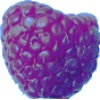

In [93]:
Image.fromarray(s, "RGB")

In [80]:
df_images.count()

96

In [125]:
def feature_extraction(col, size):
    
    features = []
    
    print(size)
    print(col[10][0])
    
#     for i in range (size):
        
#         # loading images
#         image = np.array(col[i][0]).reshape(100, 100, 3)[:, :, ::-1]
        
#         # Transform image to array and preprocessing it
#         image = np.expand_dims(image, axis=0)
#         image = preprocess_input(image)
        
#         # Getting the descriptors based on the model predict
#         vgg16_feature = model.predict(image, use_multiprocessing=True)
#         vgg16_feature = np.array(vgg16_feature)
#         vgg16_feature = vgg16_feature.flatten()
        
#         col[i][0] = vgg16_feature
        
    return col

In [126]:
features_df = df_images.select(col("path"), col("category"), feature_extraction(col("image.data"), df_images.count()).alias("features")).take(df_images.count())
#features_df.show(2)

96
Column<b'image.data[10][0]'>


In [51]:
## TensorFlow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import io

def feature_extraction(image_data):
    
    image = Image.open(io.BytesIO(content)).resize([224, 224])
    
    # Transform image to array and preprocessing it
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    
    # Getting the descriptors based on the model predict
    vgg16_feature = model.predict(image, use_multiprocessing=True)
    vgg16_feature = np.array(vgg16_feature)
    vgg16_feature = vgg16_feature.flatten()
    
    return vgg16_feature

In [45]:
features_df = df_images.select(col("path"), col("category"), feature_extraction(col("image.data")).alias("features"))

Column<b'image.data'>


TypeError: a bytes-like object is required, not 'Column'

In [37]:
df_images.withColumn("feature", feature_extraction(df_images["image"].asDict()["image"]["data"]))

TypeError: 'Column' object is not callable

In [52]:
features = df_images.select("image.data").rdd.map(lambda row: feature_extraction(row["image.data"]))

In [54]:
features.show()

AttributeError: 'PipelinedRDD' object has no attribute 'show'

In [93]:
type(img)

pyspark.sql.types.Row

In [98]:
features_df.show(2)

+--------------------+---------+--------------------+
|                path| category|            features|
+--------------------+---------+--------------------+
|s3a://oc-p8-bucke...|Raspberry|[s3a://oc-p8-buck...|
|s3a://oc-p8-bucke...|Raspberry|[s3a://oc-p8-buck...|
+--------------------+---------+--------------------+
only showing top 2 rows



In [59]:
features_df.printSchema()

root
 |-- path: string (nullable = false)
 |-- category: string (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



<div class="alert alert-block alert-info">
    <p>To make this point, we are going to download the model to the Spark driver and then broadcast the weights to the workers.<br>
        we are going to use the approach in the following <a href="https://docs.databricks.com/applications/machine-learning/preprocess-data/transfer-learning-tensorflow.html", target="blank">link</a>
    </p>
</div>